In [1]:
import sys
import os
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
from sklearn import preprocessing
import selenium
import geopandas as gp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import matrix_operation
import diffusionNMF
import grid_search
import nmf
from matrix_operation import mat_opr
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from nmf import nmf

%load_ext autoreload
%autoreload 2

In [15]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.linewidth'] = 1

In [112]:
# adjacency Laplacian
state_dset = pd.read_csv(os.path.join(par, 'collected_data/state_dataset.csv'), index_col = 0)
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0)
# json file with geographic info for each state -- required for graphing
state_map = os.path.join(par, 'collected_data/US_States_geojson.json')

In [4]:
state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)
state_L = state_L.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 0)
state_L = state_L.to_numpy()

state_dset = state_dset.drop(["Alaska", "Hawaii", "Puerto Rico"], axis = 1)

In [7]:
K1 = np.linalg.inv(np.identity(len(state_L)) + 0.01 * state_L)
k1s = preprocessing.MinMaxScaler().fit_transform(K1)
diffuse1 = pd.DataFrame(k1s, columns = state_dset.columns, index = state_dset.columns)

K2 = np.linalg.inv(np.identity(len(state_L)) + 10 * state_L)
k2s = preprocessing.MinMaxScaler().fit_transform(K2)
diffuse2 = pd.DataFrame(k2s, columns = state_dset.columns, index = state_dset.columns)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


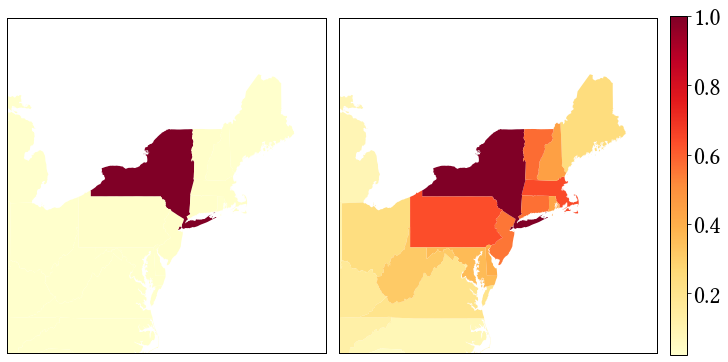

In [12]:
stateMap = gp.read_file(state_map)

val_col1 = []
val_col2 = []

for i in stateMap["NAME"]:
    try:
        val_col1.append(diffuse1.loc["New York",i])
    except:
        val_col1.append(np.nan)
for i in stateMap["NAME"]:
    try:
        val_col2.append(diffuse2.loc["New York",i])
    except:
        val_col2.append(np.nan)

stateMap['val1'] = val_col1
stateMap['val2'] = val_col2

fig,ax = plt.subplots(1,2, constrained_layout=True, figsize = (10,5))
#divider = make_axes_locatable(ax[2])
#cax = divider.append_axes("right", size="2%", pad=-0.2)

stateMap.plot(column='val1',legend=False, ax = ax[0], cmap='YlOrRd')
ax[0].set_xlim(-85, -65)
ax[0].set_ylim(35, 50)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax[0].set_title("Before Diffusion")

stateMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.95, 'aspect': 40})
ax[1].set_xlim(-85, -65)
ax[1].set_ylim(35, 50)
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax[1].set_title("After Diffusion")

plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/diff_example.pdf')

### State Figures

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


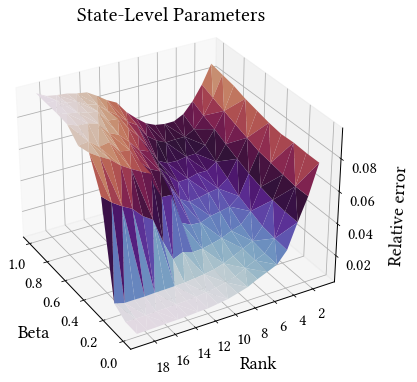

In [163]:
state_grid = pd.read_csv("./testing_data/state_grid_search_adj2.csv")
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(state_grid['beta'], state_grid['rank'], state_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("State-Level Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_grid.pdf')

In [45]:
smallest_indices = np.argsort(np.diag(state_L))[:10]
smallest = state_dset.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(state_L))))

Average node degree: 4.448979591836735


Text(0.5, 1.0, '10 Smallest degree nodes')

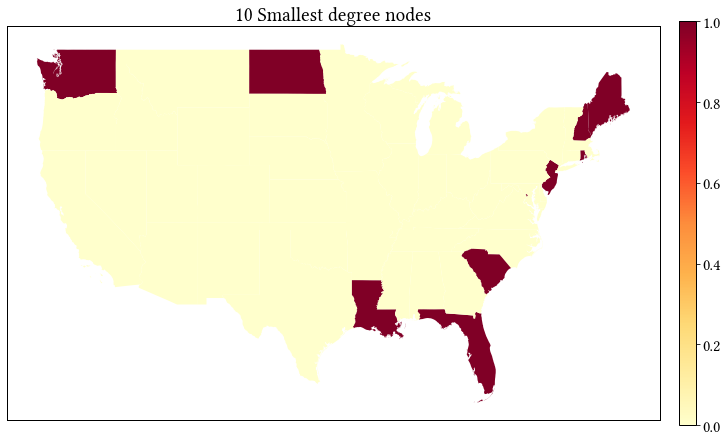

In [49]:
stateMap = gp.read_file(state_map)
val_col = []

for i in stateMap["NAME"]:
    if i in smallest:
        val_col.append(1)
    elif i in state_dset.columns:
        val_col.append(0)
    else:
        val_col.append(np.nan)

stateMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
stateMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [64]:
K = np.linalg.inv(np.identity(len(state_L)) + 0.2 * state_L)

In [65]:
# population data
population = pd.read_csv(os.path.join(par, 'collected_data/state_census_estimate.csv'), index_col = 'NAME')
state_dset = mat_opr(state_dset)
# clean + normalize
state_iso = state_dset.iso()
pop_dict = {}
for col in state_iso.dataframe.columns:
    pop_dict[col] = population.loc[col,'POP']
    
state_norm = state_iso.population_normalizer(pop_dict)

In [7]:
errs = []
for r in range(1,20):
    nmfer = nmf(r, n_iter = 100000, tol = 1e-9)
    W,H = nmfer.fit_transform(state_norm.dataframe)
    err = np.linalg.norm(state_norm.dataframe - np.dot(W,H))/np.linalg.norm(state_norm.dataframe)
    errs.append(err)

Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance
Max iterations reached, increase to converge on given tolerance


In [8]:
errs = pd.DataFrame(errs)
errs.to_csv("./testing_data/nmf_rank_errors.csv")

In [9]:
errs = pd.read_csv("./testing_data/nmf_rank_errors.csv", index_col = 0)

In [10]:
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 1

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


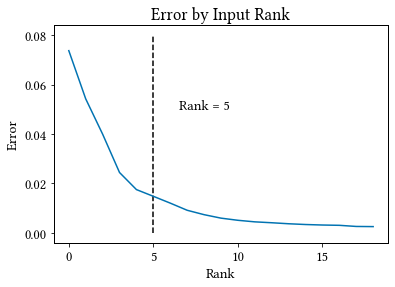

In [12]:
errs.plot(legend = False)
plt.xticks([0,5,10,15,20])
plt.yticks([0,0.02,0.04,0.06,0.08])
plt.vlines(x = 5, ymin = -0.0001, ymax = 0.08, colors = 'k', linestyles = '--', label = "rank = 6")
plt.ylabel("Error")
plt.xlabel("Rank")
plt.title("Error by Input Rank")
#plt.legend()
plt.text(6.5,0.05,"Rank = 5")
plt.savefig("test_fig.pdf")

In [66]:
rank = 5
beta = 0.2
K = np.linalg.inv(np.identity(len(state_L)) + beta * state_L)
dNMF = diffusionNMF(n_components = rank, kernel = K, n_iter = 100000  , tol = 1e-9)
X,V = dNMF.fit_transform(state_norm.dataframe)

In [67]:
X,V = rescale(X,V,K)
X = pd.DataFrame(X, index = state_norm.dataframe.index)
V = pd.DataFrame(V, columns = state_norm.dataframe.columns)

In [68]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-9)
W,H = nmfer.fit_transform(state_norm.dataframe)

In [69]:
W = pd.DataFrame(W, index = state_norm.dataframe.index)
H = pd.DataFrame(H, columns = state_norm.dataframe.columns)

In [70]:
diff_error = np.linalg.norm(state_norm.dataframe - np.dot(X, np.dot(V, K)))/np.linalg.norm(state_norm.dataframe)
nmf_error = np.linalg.norm(state_norm.dataframe - np.dot(W, H))/np.linalg.norm(state_norm.dataframe)

print("Diffusion NMF error: " + str(diff_error))
print("NMF error: " + str(nmf_error))

Diffusion NMF error: 0.01888864043036042
NMF error: 0.017437549522657327


In [ ]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [1,4,3,2,0]
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

In [116]:
#X.to_csv("./testing_data/state_X.csv")
#V.to_csv("./testing_data/state_V.csv")

X = pd.read_csv("./testing_data/state_X.csv", index_col = 0)
V = pd.read_csv("./testing_data/state_V.csv", index_col = 0)
X.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


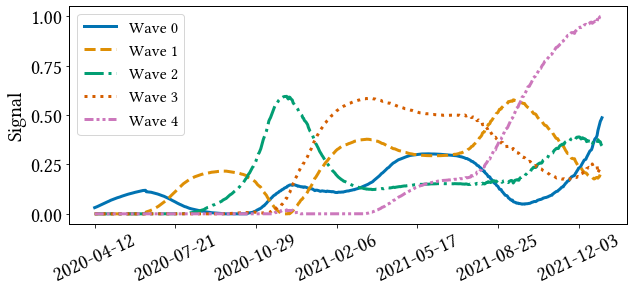

In [117]:
plt.rcParams["font.size"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
#X.plot(figsize = (10,5))
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Signal")
#plt.title("State Wide Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

In [83]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [4,3,0,1,2]
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

In [118]:
#W.to_csv("./testing_data/state_W.csv")
#H.to_csv("./testing_data/state_H.csv")

W = pd.read_csv("./testing_data/state_W.csv", index_col = 0)
H = pd.read_csv("./testing_data/state_H.csv", index_col = 0)
W.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


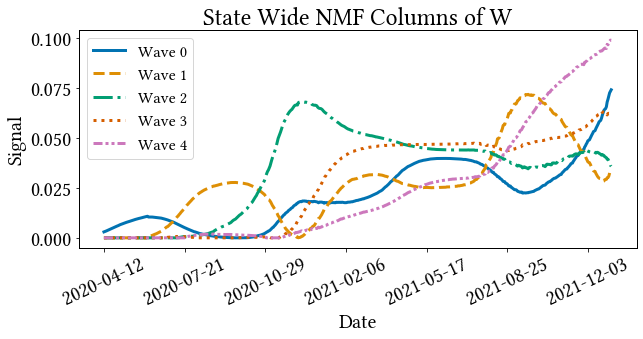

In [119]:
plt.rcParams["font.size"] = 20
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

#W.plot(figsize = (10,5))
plt.xticks(rotation = 25)
plt.xlabel("Date")
plt.ylabel("Signal")
plt.title("State Wide NMF Columns of W")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


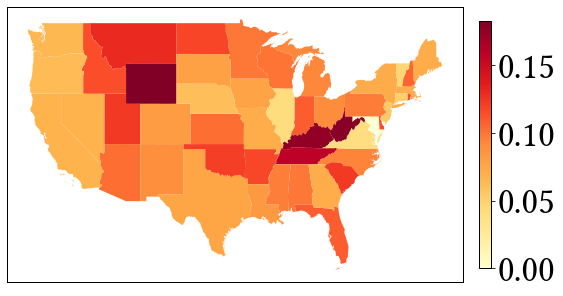

In [125]:
plt.rcParams["font.size"] = 36
stateMap = gp.read_file(state_map)
#VK = V@K
#VK.columns = V.columns
row_num = 4

val_col1 = []
val_col2 = []
for i in stateMap["NAME"]:
    try:
        val_col1.append(V.loc[row_num,i])
    except:
        pass
        val_col1.append(np.nan)

'''
for i in stateMap["NAME"]:
    try:
        val_col2.append(VK.loc[row_num,i])
    except:
        val_col2.append(np.nan)
'''

stateMap['val1'] = val_col1
#stateMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

stateMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

'''
stateMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.50, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_V' + str(row_num) + '.pdf', bbox_inches = "tight")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


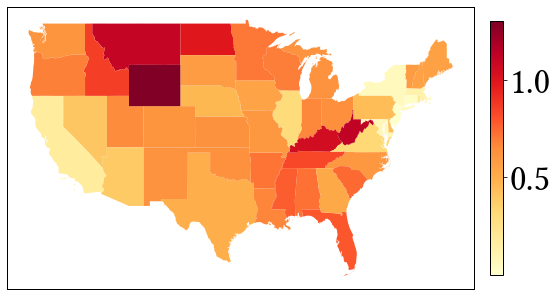

In [131]:
row_num = 4

H_col = []
for i in stateMap["NAME"]:
    try:
        H_col.append(H.loc[row_num,i])
    except:
        H_col.append(np.nan)

stateMap['val'] = H_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
stateMap.plot(column='val',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})

ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_H' + str(row_num) + '.pdf', bbox_inches = "tight")

## Counties

In [63]:
def rescale(X,V,K = None):
    X = copy.deepcopy(X)
    V = copy.deepcopy(V)

    maxer = np.amax(X)
    X /= maxer
    V *= maxer
    
    return X,V

In [64]:
# geo json map
county_map = os.path.join(par, 'collected_data/US_counties_geo.json')

# county laplacian
countyLaplacian = pd.read_csv(os.path.join(par, "collected_data/countyLaplacian.csv"), index_col = 0)
countyLaplacian.columns = countyLaplacian.columns.astype("int")

# county census data for normalization
county_pop = pd.read_csv(os.path.join(par, "collected_data/county_census.csv"), index_col = "fips")

### New England

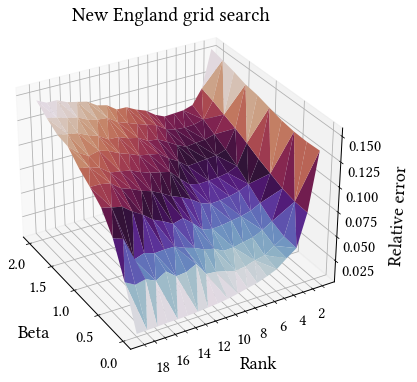

In [106]:
new_eng_grid = pd.read_csv("./testing_data/new_eng_grid2.csv")
fig = plt.figure(figsize = (14,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(new_eng_grid['beta'], new_eng_grid['rank'], new_eng_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("New England grid search")
ax.view_init(30,150)
ax.dist = 9

#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_newEng.pdf',  bbox_inches = "tight")

In [65]:
new_eng = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
new_eng = new_eng.loc[new_eng.index.get_level_values("state").isin(["New York", "Connecticut", "Maine", "Vermont",
                                                       "Massachusetts", "New Hampshire", "Rhode Island"])]
new_eng.index = new_eng.index.get_level_values("fips")
new_eng = new_eng.T

ne_lapl = countyLaplacian.loc[new_eng.columns,new_eng.columns].to_numpy()
ne_pop = county_pop.loc[new_eng.columns, :]

ne_map = os.path.join(par, 'collected_data/new_eng_counties_geo.json')

In [108]:
smallest_indices = np.argsort(np.diag(ne_lapl))[:10]
smallest = new_eng.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(ne_lapl))))

Average node degree: 5.3858267716535435


Text(0.5, 1.0, '10 Smallest degree nodes')

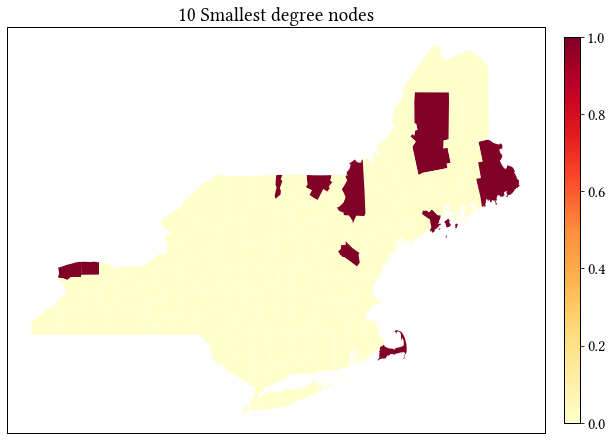

In [109]:
newEngMap = gp.read_file(ne_map)
val_col = []

for i in newEngMap["id"]:
    if int(i) in smallest:
        val_col.append(1)
    else:
        val_col.append(0)

newEngMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
newEngMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [110]:
# clean + normalize
new_eng_dset = mat_opr(new_eng)
new_eng_iso = new_eng_dset.iso()
pop_dict = {}
for col in new_eng_iso.dataframe.columns:
    pop_dict[col] = ne_pop.loc[col,'Population Estimate']        
    
new_eng_norm = new_eng_iso.population_normalizer(pop_dict)

In [114]:
rank = 5
beta = 1
neK = np.linalg.inv(np.identity(len(ne_lapl)) + beta * ne_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = neK, n_iter = 1000000, tol = 1e-10)
neX,neV = dNMF.fit_transform(new_eng_norm.dataframe)

In [115]:
neX,neV = rescale(neX,neV,neK)
neX = pd.DataFrame(neX, index = new_eng_norm.dataframe.index)
neV = pd.DataFrame(neV, columns = new_eng_norm.dataframe.columns)

In [117]:
nmfer = nmf(rank, n_iter = 1000000, tol = 1e-10)
neW,neH  = nmfer.fit_transform(new_eng_norm.dataframe)

In [118]:
neW,neH = rescale(neW,neH)
neW = pd.DataFrame(neW, index = new_eng_norm.dataframe.index)
neH = pd.DataFrame(neH, columns = new_eng_norm.dataframe.columns)

In [120]:
ne_diff_error = np.linalg.norm(new_eng_norm.dataframe - np.dot(neX, np.dot(neV, neK)))/np.linalg.norm(new_eng_norm.dataframe)
ne_nmf_error = np.linalg.norm(new_eng_norm.dataframe - np.dot(neW, neH))/np.linalg.norm(new_eng_norm.dataframe)

print("Diffusion NMF error: " + str(ne_diff_error))
print("NMF error: " + str(ne_nmf_error))

Diffusion NMF error: 0.061634155042311026
NMF error: 0.02309831360858838


In [123]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [1,3,0,2,4]
neX = neX[reorder]
neX.columns = standard
neV = neV.reindex(reorder)
neV.index = standard 

In [13]:
#neX.to_csv("./testing_data/new_england_X.csv")
#neV.to_csv("./testing_data/new_england_V.csv")

neX = pd.read_csv("./testing_data/new_england_X.csv", index_col = 0)
neV = pd.read_csv("./testing_data/new_england_V.csv", index_col = 0)
neV.columns = neV.columns.astype(int)

In [31]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.linewidth'] = 1

In [25]:
neX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

In [46]:
from collections import OrderedDict

linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 5))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


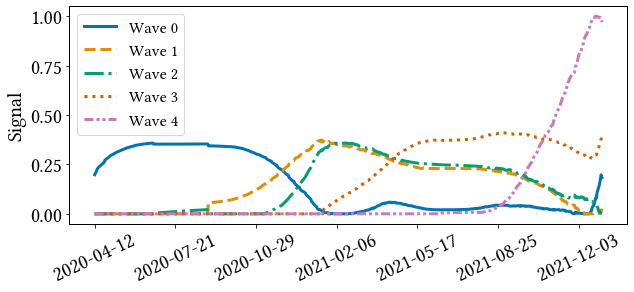

In [54]:
neX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(neX.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Signal")
#plt.title("New England Counties Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_diffX.pdf',  bbox_inches = "tight")
plt.show()

In [131]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [2,4,1,0,3]
neW = neW[reorder]
neW.columns = standard
neH = neH.reindex(reorder)
neH.index = standard 

In [58]:
#neW.to_csv("./testing_data/new_england_W.csv")
#neH.to_csv("./testing_data/new_england_H.csv")

neW = pd.read_csv("./testing_data/new_england_W.csv", index_col = 0)
neH = pd.read_csv("./testing_data/new_england_H.csv", index_col = 0)
neH.columns = neH.columns.astype(int)
neW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


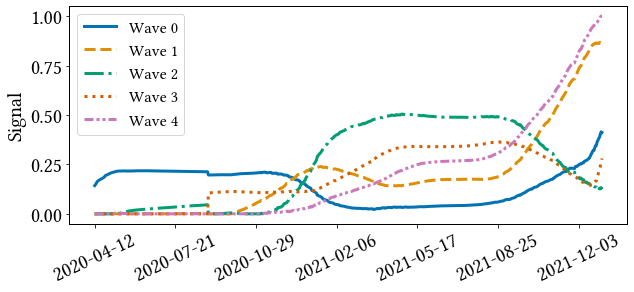

In [59]:
neW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(neW.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Signal")
#plt.title("New England Counties NMF Columns of W")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_nmfX.pdf',  bbox_inches = "tight")
plt.show()

In [71]:
plt.rcParams['font.size'] = 36

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


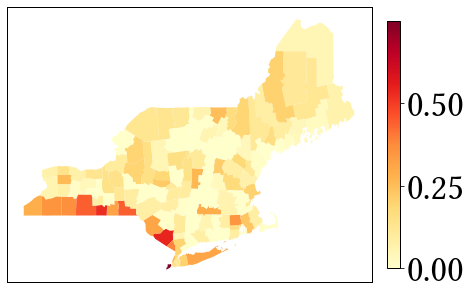

In [76]:
newEngMap = gp.read_file(ne_map)
#neVK = neV@neK
#neVK.columns = neV.columns
row_num = 4

val_col1 = []
val_col2 = []
for i in newEngMap["id"]:
    try:
        val_col1.append(neV.loc[row_num,int(i)])
    except:
        val_col1.append(np.nan)
'''
for i in newEngMap["id"]:
    try:
        val_col2.append(neVK.loc[row_num,int(i)])
    except:
        val_col2.append(np.nan)
'''
newEngMap['val1'] = val_col1
#newEngMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

newEngMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of V")

'''
newEngMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.60, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_V' + str(row_num) + '.pdf', bbox_inches = "tight")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


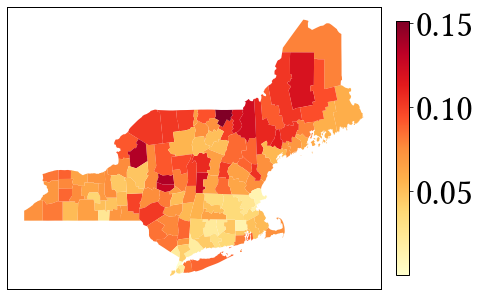

In [88]:
newEngMap = gp.read_file(ne_map)
val_col = []
row_num = 4
for i in newEngMap["id"]:
    try:
        val_col.append(neH.loc[row_num,int(i)])
    except:
        val_col.append(np.nan)

newEngMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
newEngMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/newEng_H' + str(row_num) + '.pdf', bbox_inches = "tight")

### California

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


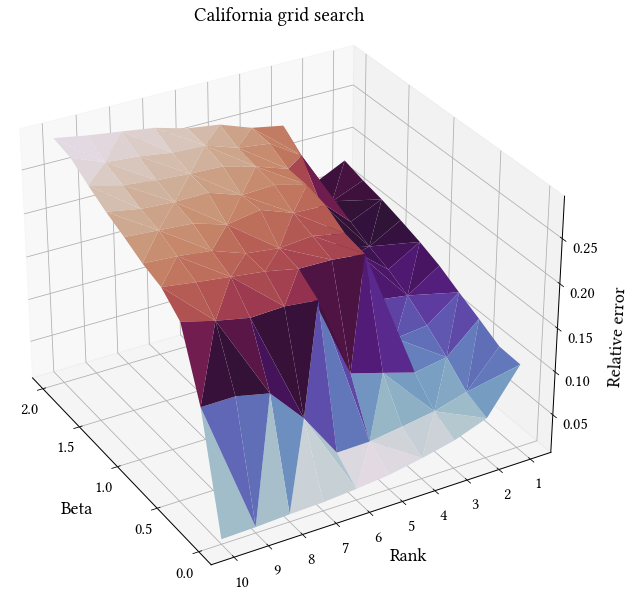

In [171]:
cali_grid = pd.read_csv("./testing_data/california_grid2.csv")
cali_grid = cali_grid[cali_grid["rank"] <= 10]
cali_grid = cali_grid.loc[cali_grid["beta"] <= 3]
fig = plt.figure(figsize = (14,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(cali_grid['beta'], cali_grid['rank'], cali_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("California grid search")
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_california.pdf')

In [89]:
cali = pd.read_csv(os.path.join(par, 'collected_data/county_dataset.csv'), index_col = [0,1,2])
cali = cali.loc[cali.index.get_level_values("state").isin(["California"])]
cali.index = cali.index.get_level_values("fips")
cali = cali.T

cali_lapl = countyLaplacian.loc[cali.columns,cali.columns].to_numpy()
cali_pop = county_pop.loc[cali.columns, :]
cali_map = os.path.join(par, 'collected_data/cali_counties_geo.json')

In [173]:
smallest_indices = np.argsort(np.diag(cali_lapl))[:10]
smallest = cali.columns[smallest_indices]
print("Average node degree: " + str(np.average(np.diag(cali_lapl))))

Average node degree: 5.4655172413793105


In [174]:
np.diag(cali_lapl)[smallest_indices]

array([3., 3., 3., 4., 4., 4., 4., 4., 4., 4.])

Text(0.5, 1.0, '10 Smallest degree nodes')

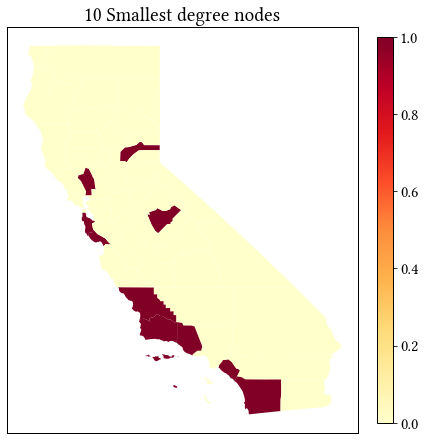

In [175]:
caliMap = gp.read_file(cali_map)
val_col = []

for i in caliMap["id"]:
    if int(i) in smallest:
        val_col.append(1)
    else:
        val_col.append(0)

caliMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (10,6))
caliMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.950, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax.set_title("10 Smallest degree nodes")

In [176]:
# clean + normalize
cali_dset = mat_opr(cali)
cali_iso = cali_dset.iso()
pop_dict = {}
for col in cali_iso.dataframe.columns:
    pop_dict[col] = cali_pop.loc[col,'Population Estimate']        
    
cali_norm = cali_iso.population_normalizer(pop_dict)

In [177]:
rank = 5
beta = 1
cK = np.linalg.inv(np.identity(len(cali_lapl)) + beta * cali_lapl)
dNMF = diffusionNMF(n_components = rank, kernel = cK, n_iter = 1000000, tol = 1e-10)
cX,cV = dNMF.fit_transform(cali_norm.dataframe)

In [178]:
cX,cV = rescale(cX,cV,cK)
cX = pd.DataFrame(cX, index = cali_norm.dataframe.index)
cV = pd.DataFrame(cV, columns = cali_norm.dataframe.columns)

In [183]:
nmfer = nmf(rank, n_iter = 1000000, tol = 1e-10)
cW,cH = nmfer.fit_transform(cali_norm.dataframe)

In [184]:
cW,cH = rescale(cW,cH)
cW = pd.DataFrame(cW, index = cali_norm.dataframe.index)
cH = pd.DataFrame(cH, columns = cali_norm.dataframe.columns)

In [185]:
cali_diff_error = np.linalg.norm(cali_norm.dataframe - np.dot(cX, np.dot(cV, cK)))/np.linalg.norm(cali_norm.dataframe)
cali_nmf_error = np.linalg.norm(cali_norm.dataframe - np.dot(cW, cH))/np.linalg.norm(cali_norm.dataframe)

print("Diffusion NMF error: " + str(cali_diff_error))
print("NMF error: " + str(cali_nmf_error))

Diffusion NMF error: 0.11072744113178014
NMF error: 0.017552949893673918


In [187]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [4,0,2,1,3]
cX = cX[reorder]
cX.columns = standard
cV = cV.reindex(reorder)
cV.index = standard 

In [94]:
#cX.to_csv("./testing_data/california_X.csv")
#cV.to_csv("./testing_data/california_V.csv")

cX = pd.read_csv("./testing_data/california_X.csv", index_col = 0)
cV = pd.read_csv("./testing_data/california_V.csv", index_col = 0)
cV.columns = cV.columns.astype(int)
cX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

In [95]:
plt.rcParams['font.size'] = 20

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


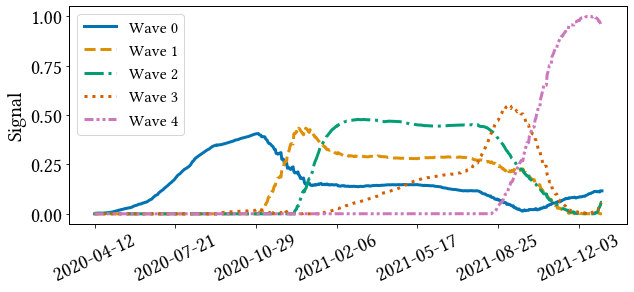

In [96]:
cX.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(cX.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()

#cX.plot(figsize = (10,4))
plt.xticks(rotation = 25)
#plt.xlabel("Date")
plt.ylabel("Signal")
#plt.title("California Counties Diffusion NMF Columns of X")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_diffX.pdf', bbox_inches = "tight")
plt.show()

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


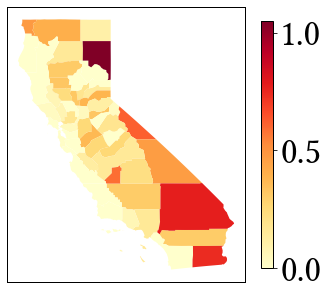

In [106]:
plt.rcParams['font.size'] = 36

caliMap = gp.read_file(cali_map)
#cVK = cV@cK
#cVK.columns = cV.columns
row_num = 4

val_col1 = []
val_col2 = []
for i in caliMap["id"]:
    try:
        val_col1.append(cV.loc[row_num,int(i)])
    except:
        val_col1.append(np.nan)
'''      
for i in caliMap["id"]:
    try:
        val_col2.append(cVK.loc[row_num,int(i)])
    except:
        val_col2.append(np.nan)
'''

caliMap['val1'] = val_col1
#caliMap['val2'] = val_col2

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

caliMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of V")

'''
caliMap.plot(column='val2',legend=True, ax = ax[1], cmap='YlOrRd', legend_kwds={'shrink': 0.95, 'aspect': 40})
ax[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[1].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
ax[1].set_title("Row " + str(row_num) + " of VK")
'''

#fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_V' + str(row_num) + '.pdf', bbox_inches = "tight")

In [192]:
# RE-order for better presentation
standard = [0,1,2,3,4]
reorder = [2,4,1,3,0]
cW = cW[reorder]
cW.columns = standard
cH = cH.reindex(reorder)
cH.index = standard 

In [97]:
#cW.to_csv("./testing_data/california_W.csv")
#cH.to_csv("./testing_data/california_H.csv")

cW = pd.read_csv("./testing_data/california_W.csv", index_col = 0)
cH = pd.read_csv("./testing_data/california_H.csv", index_col = 0)
cH.columns = cH.columns.astype(int)
cW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


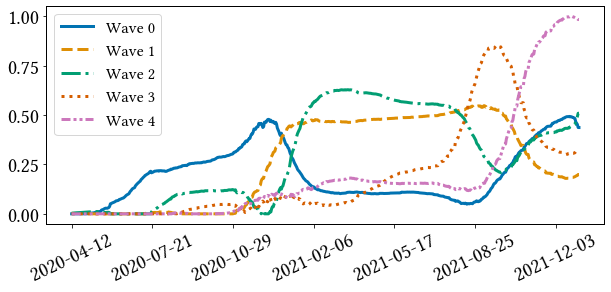

In [100]:
#fig,axs = plt.subplots(1,1,figsize = (10,5))

cW.iloc[:,:-1].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(cW.iloc[:,-1], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.legend()
plt.xticks(rotation=25)
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_nmfX.pdf', bbox_inches = "tight")
plt.show()

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


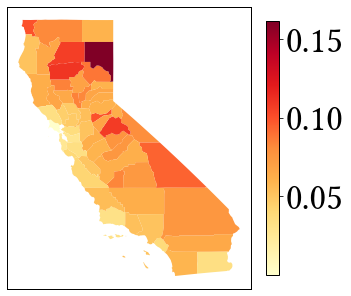

In [111]:
plt.rcParams['font.size'] = 36

caliMap = gp.read_file(cali_map)
row_num = 4

val_col = []
for i in caliMap["id"]:
    try:
        val_col.append(cH.loc[row_num, int(i)])
    except:
        val_col.append(np.nan)


caliMap['val'] = val_col

fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))
caliMap.plot(column='val', legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
#ax.set_title("Row " + str(row_num) + " of H")
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/california_H' + str(row_num) + '.pdf', bbox_inches = "tight")

### World Level

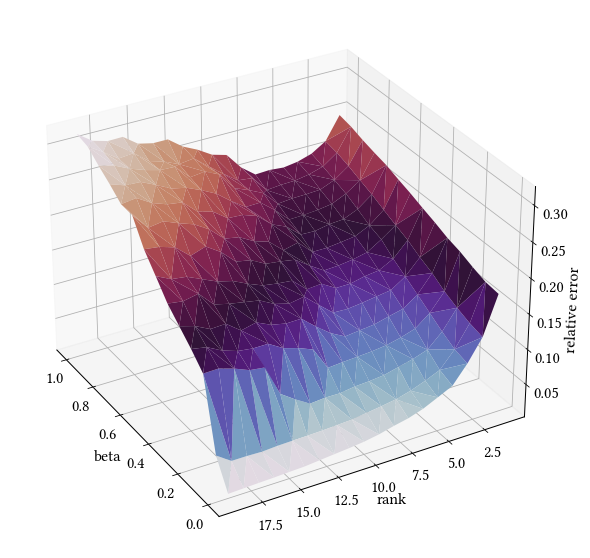

In [209]:
world_grid = pd.read_csv("./testing_data/covid_world_grid_search.csv")
world_grid = world_grid[world_grid["beta"] <= 1]
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(world_grid['beta'], world_grid['rank'], world_grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

In [143]:
world_data = pd.read_csv(os.path.join(par, 'collected_data/world_dataset.csv'), index_col = 0)
world_laplacian = pd.read_csv(os.path.join(par, 'collected_data/worldLaplacian.csv'), index_col = 0).to_numpy()
# geo json map
world_map = os.path.join(par, 'collected_data/countries_geo.geojson')
world_population = pd.read_csv(os.path.join(par, 'collected_data/world_population.csv'), index_col = "Country")

In [273]:
world_data

,USA,RUS,JPN,IND,CHN,COL,MEX,BRA,UKR,PER,...,SDN,ZMB,TWN,BGR,SAU,HND,DZA,POL,URY,KHM
2020-04-12,555271,15770,6748,9205,83134,2776,4219,22192,2777,7519,...,19,43,388,675,4462,393,1914,6674,480,122
2020-04-13,580526,18328,7370,10453,83213,2852,4661,23430,3102,9784,...,19,45,393,685,4934,397,1983,6934,480,122
2020-04-14,607220,21102,7645,11487,83306,2979,5014,25262,3372,10303,...,29,45,393,713,5369,407,2070,7202,483,122
2020-04-15,636538,24490,8100,12322,83356,3105,5399,28320,3764,11475,...,32,48,395,747,5862,419,2160,7582,492,122
2020-04-16,667773,27938,8626,13430,83403,3233,5847,30425,4161,12491,...,32,48,395,800,6380,426,2268,7918,502,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,53170421,10258052,1731048,34808886,114365,5132277,3951946,22259270,3828336,2279299,...,46292,238383,16950,737233,553921,379402,217265,4064715,408894,120469
2021-12-29,53659688,10279009,1731446,34822040,114586,5138603,3956372,22269031,3833952,2279299,...,46518,243638,16964,740682,554665,379402,217647,4080282,410311,120473
2021-12-30,54246831,10299923,1731878,34838804,114794,5147039,3961662,22281649,3840041,2292254,...,46518,249193,16988,744298,555417,379402,218037,4094608,411658,120487
2021-12-31,54743982,10320405,1732296,34861579,115042,5157440,3979723,22291839,3847226,2292254,...,46518,254274,17029,747108,556236,379402,218432,4108215,413383,120493


In [211]:
# clean + normalize
world_dset = mat_opr(world_data)
world_iso = world_dset.iso()
pop_dict = {}
for col in world_iso.dataframe.columns:
    pop_dict[col] = world_population.loc[col,'Population']
    
world_norm = world_iso.population_normalizer(pop_dict)
world_norm = world_norm.dataframe

In [216]:
rank = 7
beta = 0.1
wK = np.linalg.inv(np.identity(len(world_laplacian)) + beta * world_laplacian)
dNMF = diffusionNMF(n_components = rank, kernel = wK, n_iter = 100000, tol = 1e-9)
wX,wV = dNMF.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [218]:
wX,wV = rescale(wX, wV)
wX = pd.DataFrame(wX, index = world_norm.index)
wV = pd.DataFrame(wV, columns = world_norm.columns)

In [221]:
# RE-order for better presentation
standard = [0,1,2,3,4,5,6]
reorder = [3,0,5,2,1,4,6]
wX = wX[reorder]
wX.columns = standard
wV = wV.reindex(reorder)
wV.index = standard 

In [135]:
#wX.to_csv("./testing_data/world_X.csv")
#wV.to_csv("./testing_data/world_V.csv")

wX = pd.read_csv("./testing_data/world_X.csv", index_col = 0)
wV = pd.read_csv("./testing_data/world_V.csv", index_col = 0)
wX.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4", "Wave 5", "Wave 6"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


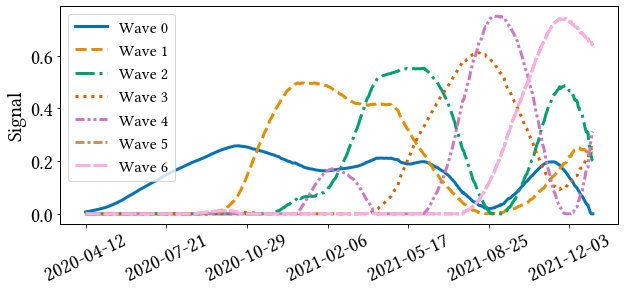

In [139]:
plt.rcParams['font.size'] = 20
#fig,axs = plt.subplots(1,1,figsize = (10,5))
wX.iloc[:,:-3].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(wX.iloc[:,-3], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.plot(wX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
plt.plot(wX.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
#wX.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation = 25)
plt.ylabel("Signal")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_diffX.pdf', bbox_inches = "tight")
plt.show()

In [214]:
nmfer = nmf(rank, n_iter = 100000, tol = 1e-9)
wW,wH = nmfer.fit_transform(world_norm)

Max iterations reached, increase to converge on given tolerance


In [229]:
wW, wH = rescale(wW, wH)
wW = pd.DataFrame(wW, index = world_norm.index)
wH = pd.DataFrame(wH, columns = world_norm.columns)

In [231]:
# RE-order for better presentation
standard = [0,1,2,3,4,5,6]
reorder = [2,6,5,3,4,1,0]
wW = wW[reorder]
wW.columns = standard
wH = wH.reindex(reorder)
wH.index = standard 

In [140]:
#wW.to_csv("./testing_data/world_W.csv")
#wH.to_csv("./testing_data/world_H.csv")

wW = pd.read_csv("./testing_data/world_W.csv", index_col = 0)
wH = pd.read_csv("./testing_data/world_H.csv", index_col = 0)
wW.columns = ["Wave 0", "Wave 1", "Wave 2", "Wave 3", "Wave 4", "Wave 5", "Wave 6"]

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


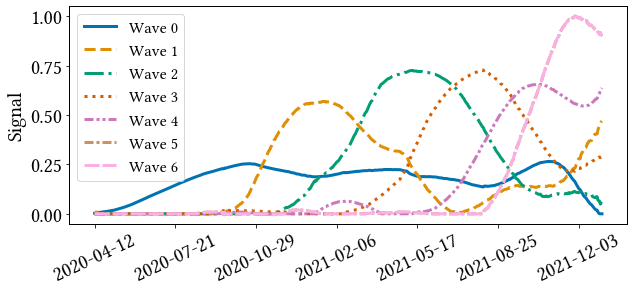

In [141]:
plt.rcParams['font.size'] = 20
#fig,axs = plt.subplots(1,1,figsize = (10,5))
wW.iloc[:,:-3].plot(figsize = (10,4), linewidth = 3, style = ['-', '--', '-.', ':'])
plt.plot(wW.iloc[:,-3], linewidth = 3, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 4")
plt.plot(wW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashdotted"], label = "Wave 5")
plt.plot(wW.iloc[:,-2], linewidth = 3, linestyle = linestyles_dict["densely dashed"], label = "Wave 6")
plt.legend()
wW.plot(figsize = (10,4), ax = axs)
#axs.tick_params(labelrotation=25)
plt.xticks(rotation=25)
plt.ylabel("Signal")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_nmfX.pdf', bbox_inches = "tight")
plt.show()

In [235]:
world_diff_error = np.linalg.norm(world_norm - np.dot(wX, np.dot(wV, wK)))/np.linalg.norm(world_norm)
world_nmf_error = np.linalg.norm(world_norm - np.dot(wW, wH))/np.linalg.norm(world_norm)

print("Diffusion NMF error: " + str(world_diff_error))
print("NMF error: " + str(world_nmf_error))

Diffusion NMF error: 0.04859966814301027
NMF error: 0.03039429484052805


'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


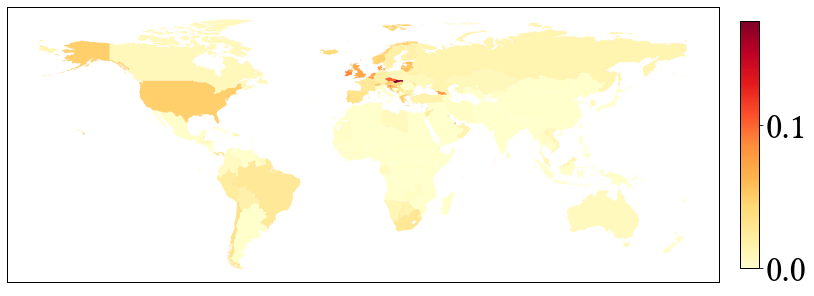

In [154]:
plt.rcParams["font.size"] = 36
worldMap = gp.read_file(world_map)
row_num = 6

val_col1 = []
for i in worldMap["ISO_A3"]:
    try:
        val_col1.append(wV.loc[row_num,i])
    except:
        val_col1.append(np.nan)


worldMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (12,4))

worldMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_V' + str(row_num) + '.pdf', bbox_inches = "tight")

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


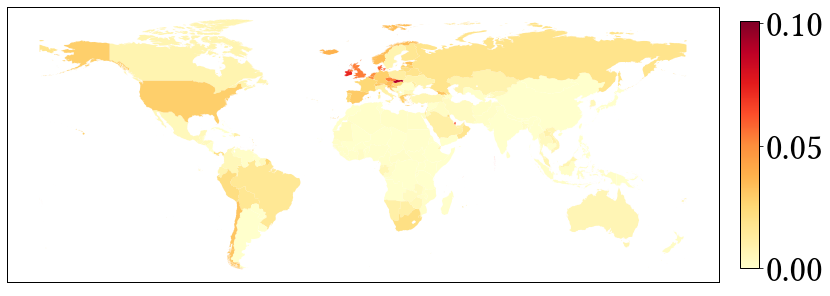

In [161]:
worldMap = gp.read_file(world_map)
row_num = 6

val_col1 = []
for i in worldMap["ISO_A3"]:
    try:
        val_col1.append(wH.loc[row_num,i])
    except:
        val_col1.append(np.nan)


worldMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (12,4))

worldMap.plot(column='val1',legend=True, ax = ax, cmap='YlOrRd', legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/world_H' + str(row_num) + '.pdf', bbox_inches = "tight")